In [32]:
%matplotlib inline

In [33]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("Number of letters: {}".format(n_letters))
print("Number of categories: {}".format(n_categories))

['data/names/French.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Polish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Greek.txt', 'data/names/Portuguese.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt', 'data/names/Korean.txt', 'data/names/Irish.txt']
Slusarski
Number of letters: 57
Number of categories: 18


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [34]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [35]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J').size())

print(lineToTensor('Jones').size())

torch.Size([1, 57])
torch.Size([5, 1, 57])


In [36]:
import torch.nn as nn
from torch.autograd import Variable

# class RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN, self).__init__()

#         self.hidden_size = hidden_size

#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(input_size + hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, input, hidden):
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.softmax(output)
#         return output, hidden

#     def initHidden(self):
#         return torch.zeros(1, self.hidden_size)

# n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)

# Each input is a tensor of seq_length, 1, 
class HomeworkNet(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_categories):
        super(HomeworkNet, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_categories)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, states):
        hidden, cell = states[0], states[1]
        out, hidden = self.lstm(input, (hidden, cell))
        out = self.fc(out.view(-1, out.size(2)))
        return self.softmax(out)
    def init_hidden(self):
        # if you call .cuda() on the model it’ll return cuda tensors instead.
        hidden = Variable(next(self.parameters()).data.new(1, 1, self.hidden_size))
        cell =  Variable(next(self.parameters()).data.new(1, 1, self.hidden_size))
        return hidden.zero_(), cell.zero_()

n_hidden = 512
rnn = HomeworkNet(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [37]:
# input must have shape (seq_len, batch, input_size)
# we unsqueeze for now
input = letterToTensor('A').unsqueeze(0)

hidden = torch.zeros(1, 1, n_hidden)
cell = torch.zeros(1, 1, n_hidden)
print(input.shape, cell.shape, hidden.shape)

output = rnn(input, (hidden, cell))

torch.Size([1, 1, 57]) torch.Size([1, 1, 512]) torch.Size([1, 1, 512])


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [38]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, 6, n_hidden)
cell = torch.zeros(1, 6, n_hidden)
output = rnn(input, (hidden, cell))
print(output)
print(output.size())

tensor([[-2.9104, -2.9069, -2.8869, -2.9321, -2.8722, -2.8882, -2.9174, -2.8688,
         -2.8895, -2.8554, -2.8555, -2.8643, -2.9327, -2.9139, -2.8906, -2.8732,
         -2.9238, -2.8510],
        [-2.9133, -2.9112, -2.8972, -2.9323, -2.8697, -2.8946, -2.9190, -2.8663,
         -2.8924, -2.8409, -2.8578, -2.8629, -2.9240, -2.9157, -2.8853, -2.8768,
         -2.9292, -2.8452],
        [-2.9132, -2.9059, -2.8853, -2.9290, -2.8692, -2.8891, -2.9181, -2.8667,
         -2.8980, -2.8520, -2.8576, -2.8673, -2.9312, -2.9189, -2.8881, -2.8737,
         -2.9266, -2.8435],
        [-2.9092, -2.9043, -2.8884, -2.9384, -2.8680, -2.8920, -2.9259, -2.8638,
         -2.9002, -2.8454, -2.8657, -2.8638, -2.9277, -2.9116, -2.8868, -2.8746,
         -2.9241, -2.8437],
        [-2.9173, -2.9062, -2.8879, -2.9304, -2.8725, -2.8922, -2.9173, -2.8651,
         -2.8911, -2.8534, -2.8629, -2.8654, -2.9304, -2.9117, -2.8924, -2.8689,
         -2.9230, -2.8450],
        [-2.9128, -2.9032, -2.8866, -2.9352, -2.86

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [39]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 17)


We will also want a quick way to get a training example (a name and its
language):




In [40]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Garofalis
category = Czech / line = Sekovora
category = Chinese / line = Rong
category = Vietnamese / line = Ma
category = Portuguese / line = Nunes
category = Scottish / line = Murray
category = Czech / line = Paisar
category = Vietnamese / line = Lieu
category = Chinese / line = Gauk
category = Chinese / line = Duan


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [41]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [42]:
learning_rate = 1e-3 # If you set this too high, it might explode. If too low, it might not learn
rnn.train()

def train(category_tensor, line_tensor):
    
    hidden, cell = rnn.init_hidden()  
    
    for letter_idx in range(line_tensor.shape[0]):
        letter = line_tensor[letter_idx].unsqueeze(0)
        output = rnn(letter, (hidden, cell))

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

category, line, category_tensor, line_tensor = randomTrainingExample()
output, loss = train(category_tensor, line_tensor)
print(loss, output)

2.9066500663757324 tensor([[-2.9084, -2.9067, -2.8911, -2.9344, -2.8742, -2.8883, -2.9189, -2.8621,
         -2.8921, -2.8474, -2.8659, -2.8619, -2.9258, -2.9131, -2.8918, -2.8764,
         -2.9262, -2.8483]], grad_fn=<LogSoftmaxBackward>)


Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [43]:
import time
import math

n_iters = 10000
print_every = 500
plot_every = 100



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 2s) 2.5855 Palmeiro / English ✗ (Portuguese)
1000 10% (0m 5s) 4.6942 Merlo / Italian ✗ (Spanish)
1500 15% (0m 8s) 0.2072 Kalakos / Greek ✓
2000 20% (0m 11s) 1.7042 Mateus / Greek ✗ (Portuguese)
2500 25% (0m 14s) 1.0746 Herback / Czech ✓
3000 30% (0m 17s) 1.8730 Giolla / Irish ✓
3500 35% (0m 20s) 3.1432 Nasato / Japanese ✗ (Italian)


KeyboardInterrupt: 

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




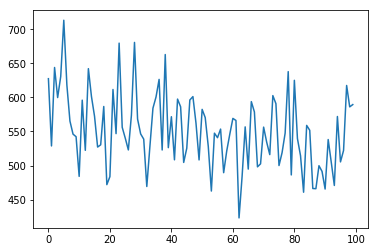

In [115]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

AttributeError: 'HomeworkNet' object has no attribute 'initHidden'

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


